In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.stats import chi2,norm
from scipy.optimize import curve_fit
import sys
import csv
import statistics
import math
import scipy.signal
from mpl_toolkits.mplot3d import Axes3D

In [12]:
def topo_info(filename, xdim, ydim, xoffset, yoffset, xlen, ylen): # Extracts informartion about the topography from an
                                                                   # # ASCII file.
    izfile = open(filename, 'r')                                   
    heights = np.zeros((ydim,xdim), float) # Apparent heights.
    n = 1
    j = 0

    for i in izfile:
        if n>(13) and n<(14+ydim):
            height_values = i.split()
            height_values = [float(i) for i in height_values]
            height_values.pop(0) # The first value of each row is number of the measurement, this removes it.
            heights[j,:] = height_values
            j += 1
        
        n += 1

    heights = np.flip(heights,1) # Need to flip the array for the correct image because of the scanning direction.
    
    xpixels = np.arange(1,xdim+1)
    ypixels = np.arange(ydim,0)
    
    x_pixel,y_pixel = np.meshgrid(xpixels,ypixels) # Coordinates in the form of pixels of the image.
    
    xcoords = np.linspace(0, xlen, xdim) 
    ycoords = np.linspace(0, ylen, ydim)
    
    x,y = np.meshgrid(xcoords,ycoords) # Coordinates in the correct dimensions but non relative to the starting position
                                       # of the STM.
    topoxrightedge = xoffset + xlen/2
    topoxleftedge = xoffset - xlen/2
    topoytopedge = yoffset + ylen/2
    topoybotedge = yoffset - ylen/2
    xcoords_real = np.linspace(topoxleftedge, topoxrightedge, xdim)
    ycoords_real = np.linspace(topoytopedge, topoybotedge, ydim)
    
    x_real,y_real = np.meshgrid(xcoords_real,ycoords_real) # "True" coordinates that take the starting position of the stm
                                                           # into account and are important for assigning the positions of the
                                                           # I-Z curves.
    return [heights, x, y, x_pixel, y_pixel, x_real, y_real]
    
def cross_image(im1, im2): # Correlates two images.
    value = scipy.signal.correlate(im1, im2, mode='same')
    return value

def func(z, k, I_0): # The exponential function used to fit the I-Z curves.
    z = [x*(-2*k) for x in z]
    return I_0*np.exp(z)

def surrmedian(image, cx, cy, w, h): # The function that finds the median of the surroundings of a suspected single-molecule.
    mask = np.logical_and(((image[1][0,:][np.newaxis,:]-cx)/(w/2.))**2 + ((image[2][:,0][:,np.newaxis]-cy)/(h/2.))**2 > 1.,
                          ((image[1][0,:][np.newaxis,:]-cx)/((w/2.)*1.5))**2 + ((image[2][:,0][:,np.newaxis]-cy)/
                                                                                ((h/2.)*1.5))**2 < 1.)
    median = np.median(image[0][mask])
    return median
    
def findzero(image, cx, cy, w, h): # A function that was used to visualize which parts of a topography would be defined as
                                   # zero height after the use of surrmedian.
    masktest = (image[0] == surrmedian(image, cx, cy, w, h))
    return image[1][masktest], image[2][masktest]

def crude_ah(image, cx, cy, w, h): # Uses the information of the ellipse outlining the single-molecule that one wants
                                          # the apparent height of to extract the apparent height via the crude method.
    testmask = ((image[1][0,:][np.newaxis,:]-cx)/(w/4.))**2 + ((image[2][:,0][:,np.newaxis]-cy)/(h/4.))**2 <= 1.
    raw_height = np.median(image[0][testmask])
    rel_height = raw_height-surrmedian(image,cx,cy,w,h)
    return rel_height

def drift_calc(im1, im2, cx, cy, w, h): # The function that calculates the drift of topographies.
    
    g1 = np.gradient(im1[0]) # This is for the methods that use the magnitudes of the gradients of the topogrpahies.
    g2 = np.gradient(im2[0])
    m1 = np.sqrt(g1[0]**2 + g1[1]**2)
    m2 = np.sqrt(g2[0]**2 + g2[1]**2)
    
    m1 -= np.mean(m1) # This is for the method that subtracts the mean of the magnitudes from the topography.
    m2 -= np.mean(m2)
    
    #m1 = im1[0]/np.mean(im1[0]) # This is for the method that uses the normalized topographies.
    #m2 = im2[0]/np.mean(im2[0])
    
    corr_sameimg = cross_image(m1,m1)
    corr_img = cross_image(m1,m2)
    
    x_corr_same = im1[1][np.unravel_index(np.argmax(corr_sameimg), corr_sameimg.shape)]
    y_corr_same = im1[2][np.unravel_index(np.argmax(corr_sameimg), corr_sameimg.shape)]
    
    x_corr = im1[1][np.unravel_index(np.argmax(corr_img), corr_img.shape)]
    y_corr = im1[2][np.unravel_index(np.argmax(corr_img), corr_img.shape)]
    
    x_drift = x_corr_same-x_corr
    y_drift = y_corr_same-y_corr
    
    return x_drift, y_drift

def izcurves(filename, curvenumber, xline, points, topofilename, xdim, ydim, xoffset, yoffset, xlen, ylen):
    # This function uses the ASCII file containing I-Z curves and the topo_info function to return all the data about the
    # I-Z curves, decay constants and the mappings hereof.
    izfile = open(filename, 'r')

    distances = [] # A list of the distances of the tip that the tip goes through at each point.
    currents_array = np.zeros((0, curvenumber), float) # An array of all current values (each row is the currents of
                                                       # all points at one distance).
    currents = [] # These will be the lists of currents per specific point.
    n = 1

    for i in izfile:
        if n==xline:
            xdata = i.split()
            xdata.pop(0)
            xdata.pop(-1) # Include this if the last current is each time a string saying "averaged". Otherwise exclude.
            xdata = [float(i) for i in xdata]
        if n==(xline+1):
            ydata = i.split()
            ydata.pop(0)
            ydata.pop(-1) # Include this if the last current is each time a string saying "averaged".
            ydata = [float(i) for i in ydata]
        if n>(xline+1) and n<(points+xline+2):
            distance_currents = i.split()
            distance_currents.pop(-1) # Include this if the last current is each time a string saying "averaged".
            distance_currents = [float(i) for i in distance_currents]
            distances.append(distance_currents.pop(0))
            currents_array = np.append(currents_array, np.array([distance_currents]), axis=0)

        n+=1
    
    for i in range(curvenumber):
        currents.append(currents_array[:,i])
    
    #plt.figure(dpi=150) # This code is able to be used to plot specific I-Z curves with the corresponding fits. 
    #for i in currents:
    #    plt.plot(distances,i,linewidth=0.5, label='I-Z curve', color='orange')
    #    popt, pcov = curve_fit(func, distances, i, p0=[6e9,5e-11])
    #    plt.plot(distances,func(distances,*popt), label='Fit', color='blue')
    #plt.legend()
    #plt.ylabel('Current [A]')
    #plt.xlabel('Distance [m]')
    #plt.xlim(right=0.6e-9)
    #plt.title('I-Z curve with an exponential fit')
    #plt.show()
    
    def coordinates(I_Z_curve): # A function that returns the coordinates of a certain I-Z curve by using its index.
        return [xdata[I_Z_curve],ydata[I_Z_curve]]

    tempcoords = coordinates(0)
    equal_points = []
    positions = [] # All the positions that measurements get taken of in order
    decay_constants = [] # Decay constants of the positions in order
    decay_var = []
    #plt.figure(dpi=150) # All the plt's from this one until the plt.show() are for plotting all the fully averaged I-Z curves
                         # with their corresponding fits.
    
    for i in range(len(currents)):
        if tempcoords == coordinates(i):
            equal_points.append(currents[i])
        else:
            summed_currents = [sum(j) for j in zip(*equal_points)]
            averaged_currents = [(j / len(equal_points)) for j in summed_currents]
            #plt.plot(distances,averaged_currents,linewidth=0.5)
            diff = []
            for j in equal_points:
                diff.append((j-averaged_currents)**2)
            diffsum = np.sum(diff, axis=0)
            var = diffsum/(len(equal_points)-1)
            std = np.sqrt(var)
            popt, pcov = curve_fit(func, distances, averaged_currents, sigma=std, p0=[6e9,5e-11])
            decay_constants.append(popt[0])
            decay_var.append(np.diag(pcov)[0])
            #plt.errorbar(distances, averaged_currents, yerr = std, fmt='.', color='orange', ecolor='lightgray',
                         #elinewidth=1, capsize=0, label='Averaged I-Z curves')
            #plt.plot(distances,func(distances,*popt), color='blue', label='Fit') # This is a plot of the fits
            equal_points = [currents[i]]
            positions.append(tempcoords)
    
        tempcoords = coordinates(i)

    # Add this once more after the for loop for the last position.
    summed_currents = [sum(j) for j in zip(*equal_points)]
    averaged_currents = [(j / len(equal_points)) for j in summed_currents]
    diff = []
    for j in equal_points:
        diff.append((j-averaged_currents)**2)
    diffsum = np.sum(diff, axis=0)
    var = diffsum/(len(equal_points)-1)
    std = np.sqrt(var)
    equal_points = [currents[i]]
    #plt.plot(distances,averaged_currents,linewidth=0.5)
    popt, pcov = curve_fit(func, distances, averaged_currents, sigma=std, p0=[6e9,5e-11])
    decay_constants.append(popt[0])
    decay_var.append(np.diag(pcov)[0])
    #plt.errorbar(distances, averaged_currents, yerr = std, fmt='.', color='orange', ecolor='lightgray', elinewidth=1,
                 #capsize=0, label='Averaged I-Z curves')
    #plt.plot(distances,func(distances,*popt), color='blue', label='Fit')
    positions.append(tempcoords)
    
    #plt.ylabel('Current [A]')
    #plt.xlabel('Distance [m]')
    #plt.xlim(right=0.6e-9)
    #plt.legend()
    #plt.title('Fit of the average of all I-Z curves')
    #plt.show()

    xpositions = []
    ypositions = []

    for i in positions:
        xpositions.append(i[0])
        ypositions.append(i[1])
        
    xpositions_unique = list(dict.fromkeys(xpositions))
    ypositions_unique = list(dict.fromkeys(ypositions))

    x,y=np.meshgrid(xpositions_unique,ypositions_unique)
    z=np.zeros(x.shape,dtype=float) # This will be the array representing the decay
                                    # constants per point

    for i in range(len(xpositions_unique)):
        for j in range(len(ypositions_unique)):
            z[i,j] = decay_constants[positions.index([x[i,j],y[i,j]])]

    plt.figure() # This is mapping of the fully averaged decay constants without a topography under it.
    p = plt.imshow(z, cmap='afmhot', extent =[x.max(), x.min(), y.min(), y.max()]) # Extent makes sure it shows in the actual
    plt.colorbar(p)                                                                # coordinates. Can express axis in pixels if
    plt.title('2D mapping of k')                                                   # it is removed.
    plt.ylabel('y [m]')
    plt.xlabel('x [m]')
    plt.show()
    
    xpositions = []
    ypositions = []

    for i in positions:
        xpositions.append(i[0])
        ypositions.append(i[1])


    topo = topo_info(topofilename, xdim, ydim, xoffset, yoffset, xlen, ylen)

    plt.figure(dpi=150) # This plots the topography that the decay constants will be mapped over.
    p = plt.imshow(topo[0], cmap='YlOrBr_r', extent =[topo[1].min(), topo[1].max(), topo[2].max(), topo[2].min()])
    cbar = plt.colorbar(p)
    cbar.set_label('Apparent height [m]')
    plt.title('Topography')                                                              
    plt.ylabel('y [m]')
    plt.xlabel('x [m]')
    plt.show()
    
    xpositions = np.array(xpositions)
    ypositions = np.array(ypositions)
    decay_constants = np.array(decay_constants)
    decay_var = np.array(decay_var)
    mask = np.logical_and(np.logical_and(topo[5].min()<=xpositions,xpositions<=topo[5].max()),
                          np.logical_and(topo[6].min()<=ypositions,ypositions<=topo[6].max()))
    decay_constants = decay_constants[mask]
    decay_var = decay_var[mask]
    
    weights = 1/decay_var
    weighted_av = np.sum(weights*decay_constants)/np.sum(weights)
    error_weighted_av = np.sqrt(1/np.sum(weights))
    print('Weighted average =',weighted_av,'+/-',error_weighted_av)
    print('Minimum decay constant =',min(decay_constants))
    print('Maximum decay constant =',max(decay_constants))
    print('Maximum error of a decay constant =',np.sqrt(max(decay_var)))
    
    plt.figure(dpi=150) # This plots the decay constant mapping
    p = plt.imshow(topo[0], cmap='YlOrBr_r', extent =[topo[5].min(), topo[5].max(), topo[6].min(), topo[6].max()])
    pbar = plt.colorbar(p) 
    pbar.set_label('Apparent height [m]')
    s = plt.scatter(xpositions[mask], ypositions[mask], c=decay_constants, cmap='winter', alpha=1, s=10)
    sbar = plt.colorbar(s)  
    sbar.set_label('Decay Constant')
    plt.title('Decay constants mapping')                                                              
    plt.ylabel('y [m]')
    plt.xlabel('x [m]')
    plt.show()
    
    for n in [0,7,6,5,4,3,2,1]: # This obtaines eight different mappings by each time using the n'th curve of all points.
        counter = n
        decay = []
        decay_var = []
    
        for i in currents:
            if (counter%8)==0:
                popt2, pcov2 = curve_fit(func, distances, i, p0=[6e9,5e-11])
                decay.append(popt2[0])
                decay_var.append(np.diag(pcov2)[0])
            counter += 1
        
        decay = np.array(decay)
        decay_var = np.array(decay_var)
        decay = decay[mask]
        decay_var = decay_var[mask]
        weights = 1/decay_var
        weighted_av = np.sum(weights*decay)/np.sum(weights)
        error_weighted_av = np.sqrt(1/np.sum(weights))
        print('Weighted average =',weighted_av,'+/-',error_weighted_av)
        print('Minimum decay constant =',min(decay))
        print('Maximum decay constant =',max(decay))
        print('Maximum error of a decay constant =',np.sqrt(max(decay_var)))
        
        plt.figure(dpi=150)
        p = plt.imshow(topo[0], cmap='YlOrBr_r', extent =[topo[5].min(), topo[5].max(), topo[6].min(), topo[6].max()])
        pbar = plt.colorbar(p) 
        pbar.set_label('Apparent height [m]')
        s = plt.scatter(xpositions[mask], ypositions[mask], c=decay, cmap='winter', alpha=1, s=10)
        sbar = plt.colorbar(s)  
        sbar.set_label('Decay Constant')
        plt.title('Decay constants mapping')                                                              
        plt.ylabel('y [m]')
        plt.xlabel('x [m]')
        plt.show() 
    
    evencount = 0
    tempcur = []
    tempcur1 = []
    tempcur2 = []
    decay1 = []
    decay2 = []
    decay1_var = []
    decay2_var = []
    
    for i in currents: # This obtaines two mappings for each direction of measurement.
                       # Namely the retracting and approaching ones.
        if len(tempcur1)==4:
            sumtempcur1 = [sum(j) for j in zip(*tempcur1)]
            avtempcur1 = [(j / 4) for j in sumtempcur1]
            diff = []
            for j in tempcur1:
                diff.append((j-avtempcur1)**2)
            diffsum = np.sum(diff, axis=0)
            var = diffsum/(len(tempcur1)-1)
            std = np.sqrt(var)
            popt3, pcov3 = curve_fit(func, distances, avtempcur1, sigma=std, p0=[6e9,5e-11])
            #plt.figure(dpi=150) # This plot is used to depict retracting averaged I-Z curves with their corresponding fits.
            #plt.errorbar(distances, avtempcur1, yerr = std, fmt='.', color='orange', ecolor='lightgray', elinewidth=1,
            #             capsize=0, label='Averaged I-Z curves')
            #plt.plot(distances,func(distances,*popt3), label='Fit')
            #plt.legend()
            #plt.ylabel('Current [A]')
            #plt.xlabel('Distance [m]')
            #plt.title('Fit of retracting averaged I-Z curves')
            #plt.xlim(right=0.6e-9)
            #plt.show()
            decay1.append(popt3[0])
            decay1_var.append(np.diag(pcov3)[0])
            tempcur1 = []
        if len(tempcur2)==4:
            sumtempcur2 = [sum(j) for j in zip(*tempcur2)]
            avtempcur2 = [(j / 4) for j in sumtempcur2]
            diff = []
            for j in tempcur2:
                diff.append((j-avtempcur2)**2)
            diffsum = np.sum(diff, axis=0)
            var = diffsum/(len(tempcur2)-1)
            std = np.sqrt(var)
            popt4, pcov4 = curve_fit(func, distances, avtempcur2, sigma=std, p0=[6e9,5e-11])
            decay2.append(popt4[0])
            decay2_var.append(np.diag(pcov4)[0])
            tempcur2 = []
        if (evencount%2)==0:
            tempcur1.append(i)
        if (evencount%2)==1:
            tempcur2.append(i)      
        evencount += 1
        
    sumtempcur2 = [sum(j) for j in zip(*tempcur2)]
    avtempcur2 = [(j / 4) for j in sumtempcur2]
    diff = []
    for i in tempcur2:
        diff.append((i-avtempcur2)**2)
    diffsum = np.sum(diff, axis=0)
    var = diffsum/(len(tempcur2)-1)
    std = np.sqrt(var)
    popt4, pcov4 = curve_fit(func, distances, avtempcur2, sigma=std, p0=[6e9,5e-11])
    decay2.append(popt4[0])
    decay2_var.append(np.diag(pcov4)[0])
    
    decay1 = np.array(decay1)
    decay2 = np.array(decay2)
    decay1_var = np.array(decay1_var)
    decay2_var = np.array(decay2_var)
    decay1 = decay1[mask]
    decay2 = decay2[mask]
    decay1_var = decay1_var[mask]
    decay2_var = decay2_var[mask]
    
    decay_island = []      # This part is to calculate the weighted average and its error in and outside the island for the
    decay_island_var = []  # retracting averaged mapping.
    decay_surr = []
    decay_surr_var = []
    for i in range(len(decay1)):
        if i>50 and i<58:
            decay_island.append(decay1[i])
            decay_island_var.append(decay1_var[i])
        if i>66 and i<76:
            decay_island.append(decay1[i])
            decay_island_var.append(decay1_var[i])
        if i>82 and i<93:
            decay_island.append(decay1[i])
            decay_island_var.append(decay1_var[i])
        if i>98 and i<108:
            decay_island.append(decay1[i])
            decay_island_var.append(decay1_var[i])
        else:
            decay_surr.append(decay1[i])
            decay_surr_var.append(decay1_var[i])
            
    weights_island = 1/np.array(decay_island_var)
    weighted_av_island = np.sum(weights_island*decay_island)/np.sum(weights_island)
    error_weighted_av_island = np.sqrt(1/np.sum(weights_island))
    weights_surr = 1/np.array(decay_surr_var)
    weighted_av_surr = np.sum(weights_surr*decay_surr)/np.sum(weights_surr)
    error_weighted_av_surr = np.sqrt(1/np.sum(weights_surr))
    
    print('Weighted average in the island =',weighted_av_island,'+/-',error_weighted_av_island)
    print('Weighted average outside of the island =',weighted_av_surr,'+/-',error_weighted_av_surr)
    
    weights1 = 1/decay1_var
    weighted_av1 = np.sum(weights1*decay1)/np.sum(weights1)
    error_weighted_av1 = np.sqrt(1/np.sum(weights1))
    weights2 = 1/decay2_var
    weighted_av2 = np.sum(weights2*decay2)/np.sum(weights2)
    error_weighted_av2 = np.sqrt(1/np.sum(weights2))
    
    print('Weighted average =',weighted_av1,'+/-',error_weighted_av1)
    print('Minimum decay constant =',min(decay1))
    print('Maximum decay constant =',max(decay1))
    print('Maximum error of a decay constant =',np.sqrt(max(decay1_var)))
        
    plt.figure(dpi=150) # This plots the decay constant mapping of the retracting averaged I-Z curves.
    p = plt.imshow(topo[0], cmap='YlOrBr_r', extent =[topo[5].min(), topo[5].max(), topo[6].min(), topo[6].max()])
    pbar = plt.colorbar(p) 
    pbar.set_label('Apparent height [m]')
    s = plt.scatter(xpositions[mask], ypositions[mask], c=decay1, cmap='winter', alpha=1, s=10)
    sbar = plt.colorbar(s)  
    sbar.set_label('Decay Constant')
    plt.title('Retracting measurements')                                                              
    plt.ylabel('y [m]')
    plt.xlabel('x [m]')
    plt.show() 
    
    print('Weighted average =',weighted_av2,'+/-',error_weighted_av2)
    print('Minimum decay constant =',min(decay2))
    print('Maximum decay constant =',max(decay2))
    print('Maximum error of a decay constant =',np.sqrt(max(decay2_var)))
        
    plt.figure(dpi=150) # This plots the decay constant mapping of the approaching averaged I-Z curves.
    p = plt.imshow(topo[0], cmap='YlOrBr_r', extent =[topo[5].min(), topo[5].max(), topo[6].min(), topo[6].max()])
    pbar = plt.colorbar(p) 
    pbar.set_label('Apparent height [m]')
    s = plt.scatter(xpositions[mask], ypositions[mask], c=decay2, cmap='winter', alpha=1, s=10)
    sbar = plt.colorbar(s)  
    sbar.set_label('Decay Constant')
    plt.title('Approaching measurements')                                                              
    plt.ylabel('y [m]')
    plt.xlabel('x [m]')
    plt.show() 
    
def twoDgaussian(mesh, offset, A, xo, yo, theta, sigma_x, sigma_y): # The 2D gaussian function used to fit the molecules.
    x,y = mesh
    a = (np.cos(theta)**2)/(2*sigma_x**2)+(np.sin(theta)**2)/(2*sigma_y**2)
    b = (np.sin(2*theta))/(4*sigma_x**2)-(np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2)+(np.cos(theta)**2)/(2*sigma_y**2)
    gaus = offset+A*np.exp(-(a*(x-xo)**2+2*b*(x-xo)*(y-yo)+c*(y-yo)**2))
    return gaus.ravel()

def paraboloid(mesh, offset, A, xo, yo, b, c): # The paraboloid function used to fit the molecules.
    x,y = mesh
    z = (-((x-xo)**2)/(b**2)-((y-yo)**2)/(c**2)+offset)*A
    z = z.clip(min=0)
    return z.ravel()

def TwoDfits(image, cx, cy, w, h): # This function returns all the information that is needed to plot the 3D topographies of the
                                   # suspected single-molecule and the 2D fits of them. It also returns the information that is
                                   # needed to extract the apparent heights from the fits with their errors.
    mask = ((image[1][0,:][np.newaxis,:]-cx)/(w/2.))**2 + ((image[2][:,0][:,np.newaxis]-cy)/(h/2.))**2 <= 1.
    xmask = (((image[1][0,:][np.newaxis,:]-cx)/(w/2.))**2 <= 1.).ravel()
    ymask = (((image[2][:,0][:,np.newaxis]-cy)/(h/2.))**2 <= 1.).ravel()
    Z = np.where(mask, image[0]-surrmedian(image, cx, cy, w, h), 0)
    X = image[1]
    Y = image[2]
    popt, pcov = curve_fit(twoDgaussian, (X,Y), Z.ravel(), p0=[0, np.max(Z), cx, cy, 0, 0.5*w, 0.5*h])
    popt2, pcov2 = curve_fit(paraboloid, (X,Y), Z.ravel(), p0=[1, 1e-9, cx, cy, 0.5*w, 0.5*h])
    gaussfit_raw = twoDgaussian((X,Y), *popt)
    gaussfit = gaussfit_raw.reshape(np.shape(image[1]))
    parafit_raw = paraboloid((X,Y), *popt2)
    parafit = parafit_raw.reshape(np.shape(image[1]))
    
    return Z, X, Y, gaussfit, parafit, popt, pcov, popt2, pcov2

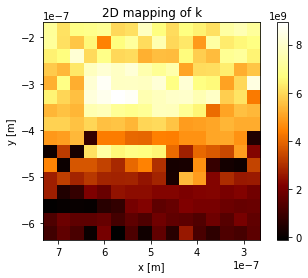

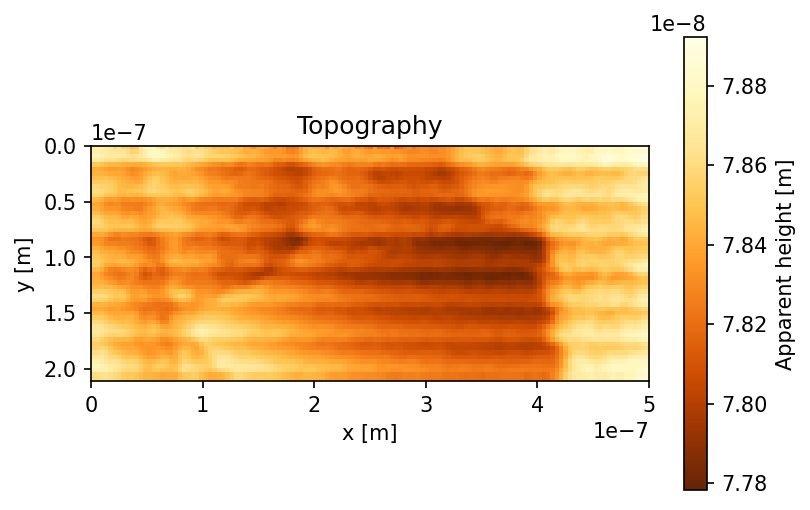

Weighted average = 6086552621.71689 +/- 8006499.444885119
Minimum decay constant = 4074076269.5972805
Maximum decay constant = 8919233017.567204
Maximum error of a decay constant = 227613189.97523195


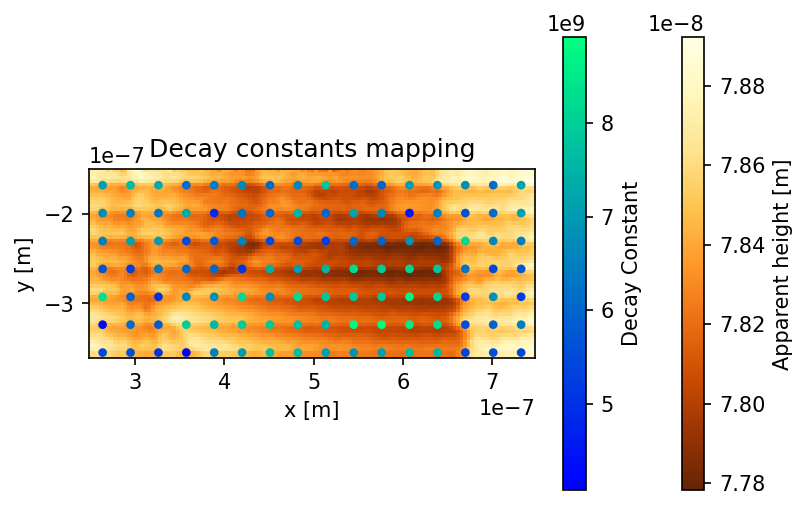

C:\Users\AKral\AppData\Local\Temp/ipykernel_2792/2469450860.py:48: RuntimeWarning: overflow encountered in exp
  return I_0*np.exp(z)


Weighted average = 5000876873.789599 +/- 10510931.171138747
Minimum decay constant = 2602568752.0701814
Maximum decay constant = 11967850178.38099
Maximum error of a decay constant = 373831313.4297169


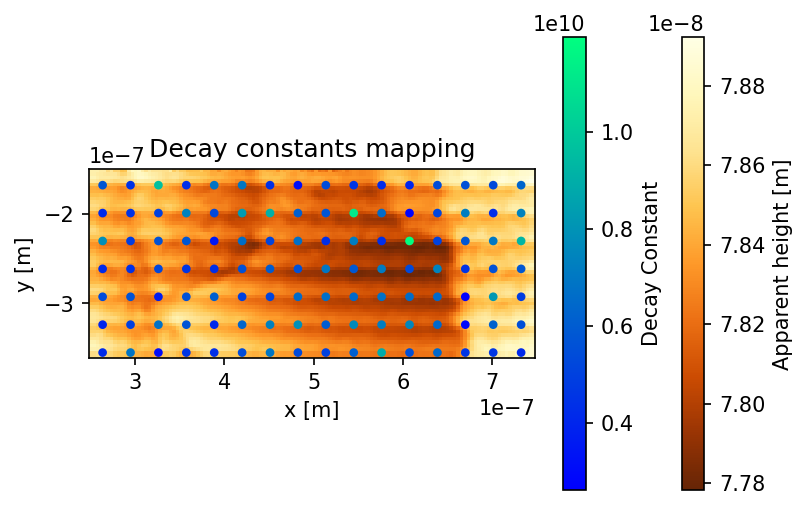

Weighted average = 5600984261.90057 +/- 10580281.499658601
Minimum decay constant = 2969669120.967556
Maximum decay constant = 17224770035.658863
Maximum error of a decay constant = 613362077.1584105


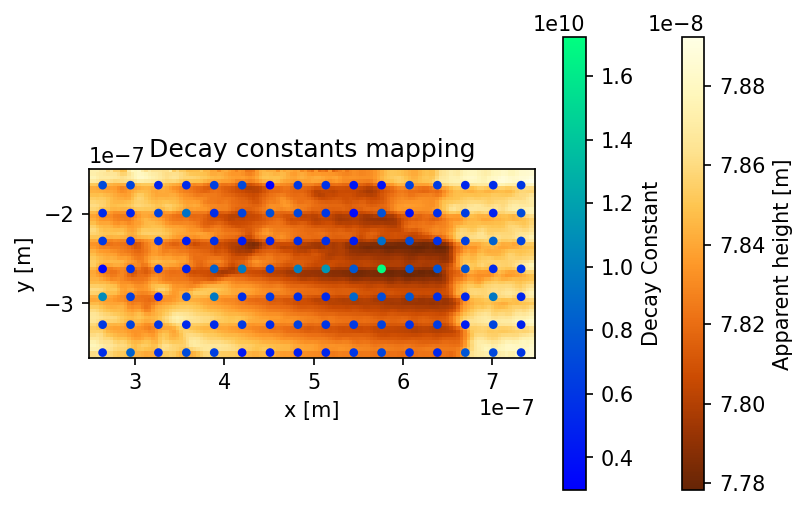

Weighted average = 5036535202.275326 +/- 9461624.507447135
Minimum decay constant = 3378094280.969891
Maximum decay constant = 12863239036.55396
Maximum error of a decay constant = 509872602.5620386


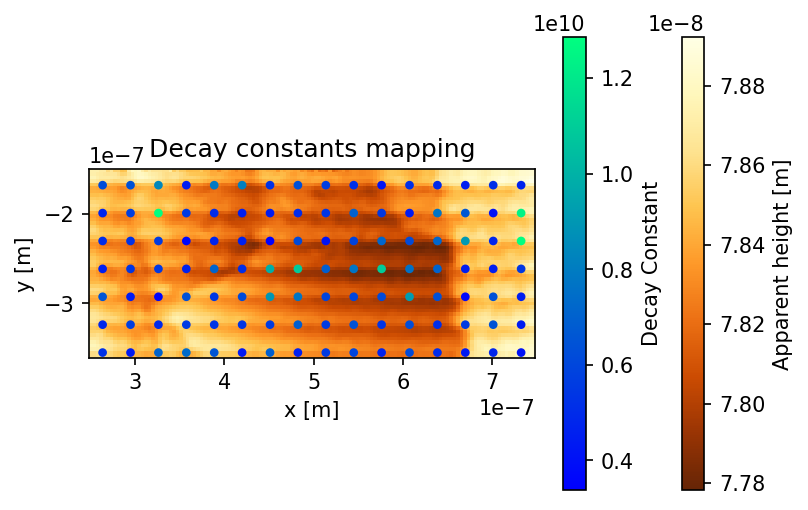

Weighted average = 5366492064.979797 +/- 10770697.744582161
Minimum decay constant = 3072552535.2815347
Maximum decay constant = 14391496786.568508
Maximum error of a decay constant = 657735466.3036741


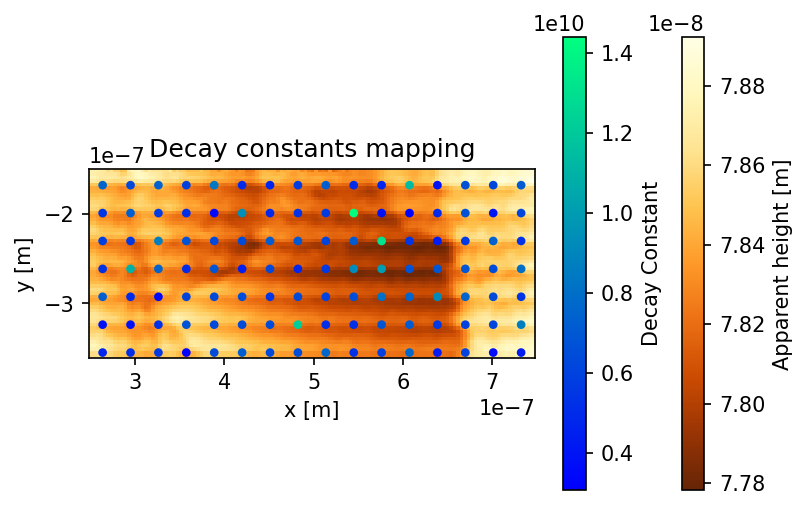

Weighted average = 5101777931.994509 +/- 10059143.616907587
Minimum decay constant = 2581303882.939644
Maximum decay constant = 13725596284.243666
Maximum error of a decay constant = 485440000.6677777


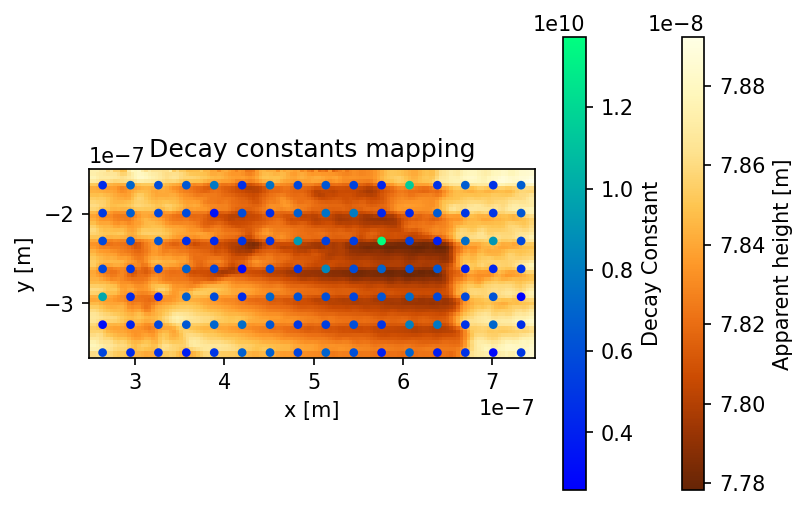

Weighted average = 5826656916.585154 +/- 11584647.593138853
Minimum decay constant = 3312396789.697282
Maximum decay constant = 14012452576.68047
Maximum error of a decay constant = 411335395.73096126


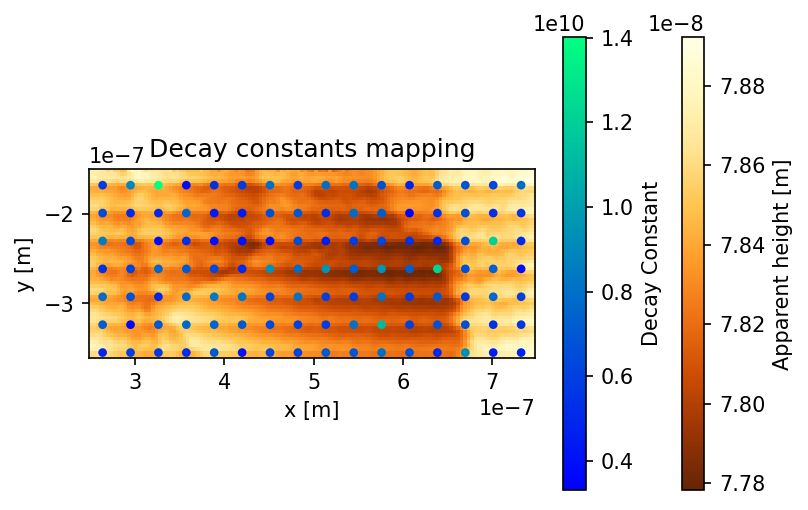

Weighted average = 5142191294.937514 +/- 10139780.027000906
Minimum decay constant = 3270468843.210954
Maximum decay constant = 13273200035.241962
Maximum error of a decay constant = 502059720.7781912


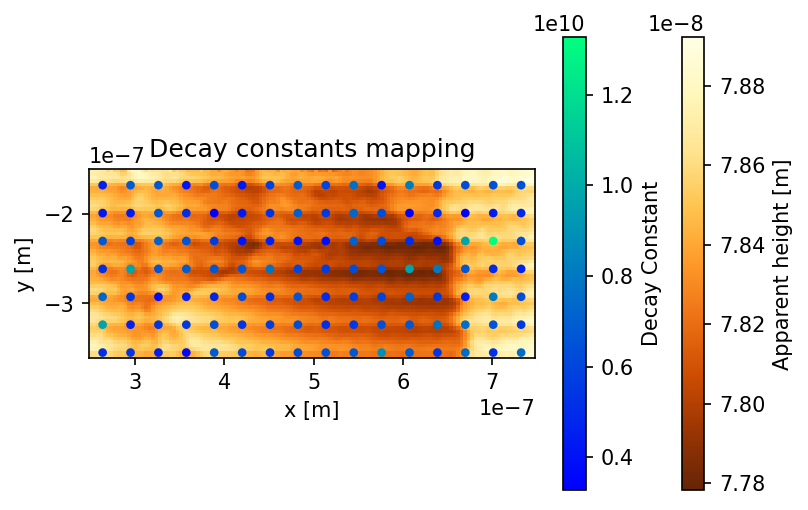

Weighted average = 5431572438.335645 +/- 10761497.743734518
Minimum decay constant = 2518732757.242717
Maximum decay constant = 17233614305.83077
Maximum error of a decay constant = 1017233806.5569112


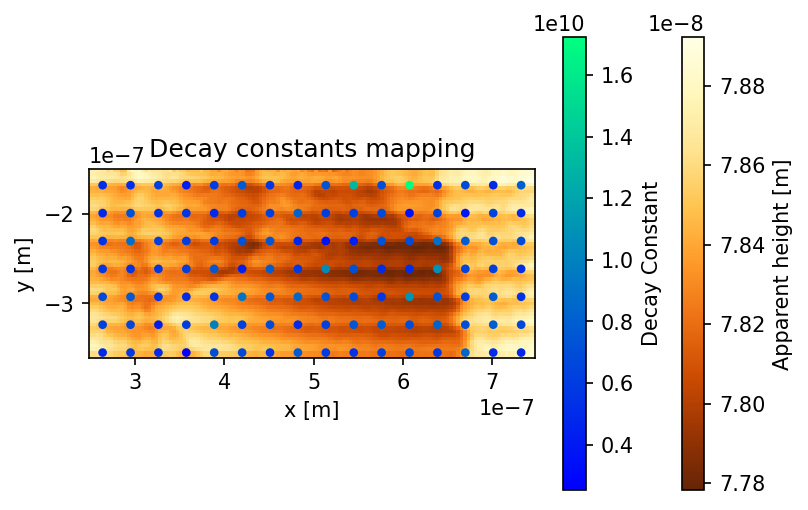

Weighted average in the island = 7441252485.355647 +/- 22026017.73007229
Weighted average outside of the island = 5814397065.772255 +/- 7917852.320703853
Weighted average = 5849255131.262857 +/- 7782030.071533281
Minimum decay constant = 1813802433.4535487
Maximum decay constant = 9141796475.186256
Maximum error of a decay constant = 207718628.79609826


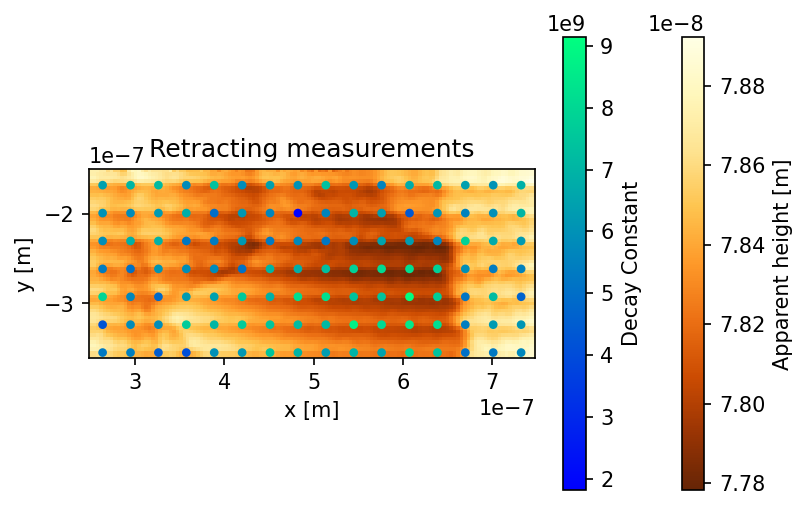

Weighted average = 6023690902.484696 +/- 12197422.528823666
Minimum decay constant = 306955297.8560595
Maximum decay constant = 9906551000.123796
Maximum error of a decay constant = 447985269.8381724


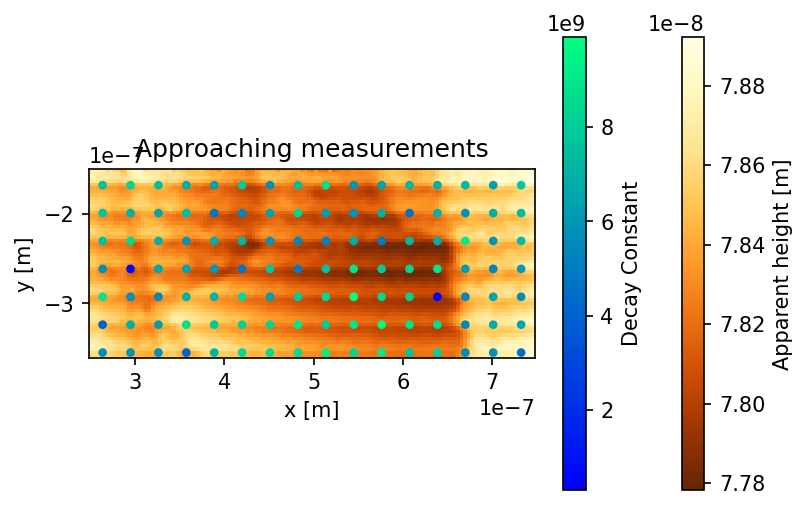

In [13]:
# This function call returns all the previously mentioned information of the nickel sample.
izcurves('ni-tip-cleaning_2022_06_08_11_34_55_356_curves.txt', 2048, 20, 301,
         'ni-tip-cleaning_2022_06_08_11_34_55_356_crop.txt', 129, 54, 498.047e-9, -255.469e-9, 500e-9, 211e-9)

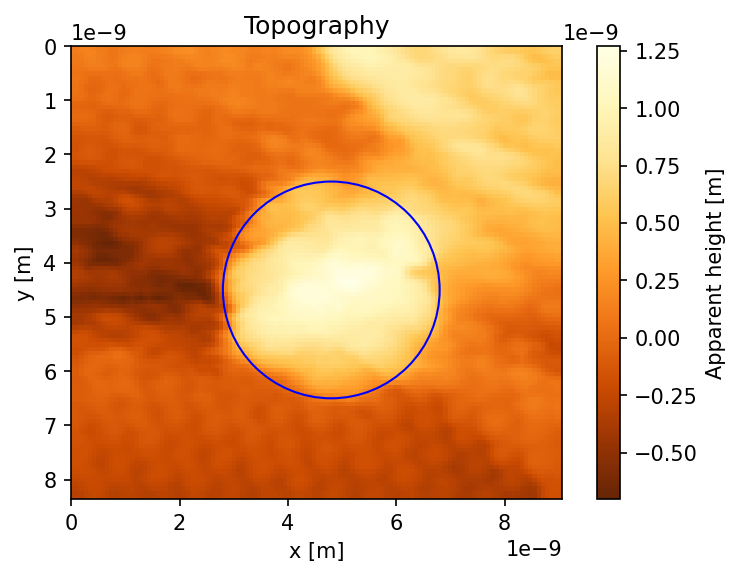

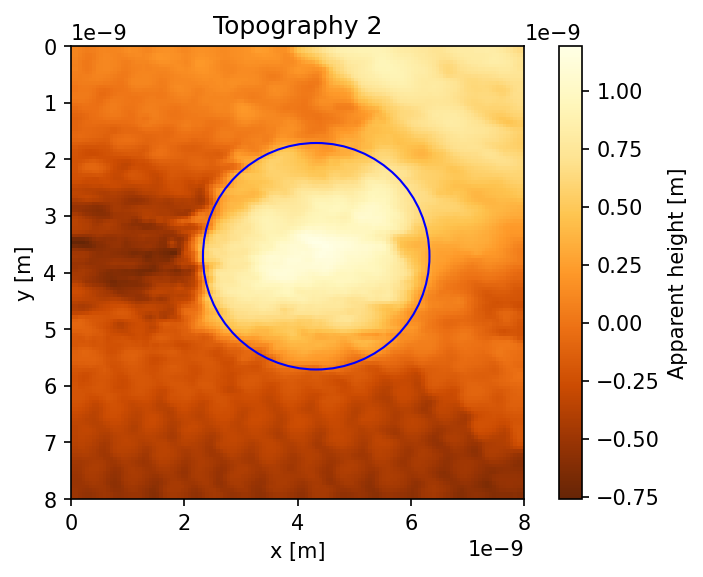

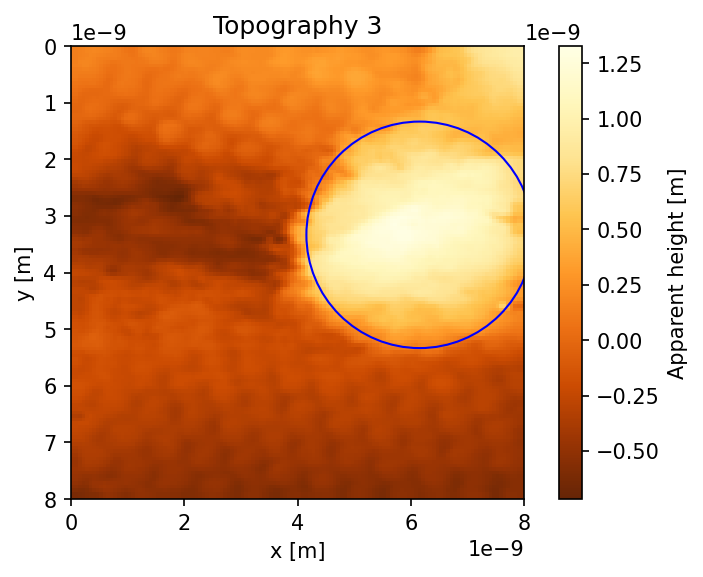

In [14]:
# The following part of the code illustrates the tracking of the drift of the test series.

mol_one = topo_info('testing_2020_03_06_21_41_12_604.txt', 116, 107, -58.109e-9, -74.180e-9, 9.06e-9, 8.36e-9)
mol_two = topo_info('testing_2020_03_06_21_43_09_433.txt', 128, 128, -57.7e-9, -73.8e-9, 8e-9, 8e-9)
mol_three = topo_info('testing_2020_03_06_21_49_15_227.txt', 128, 128, -57.7e-9, -68.2e-9, 8e-9, 8e-9)

img_one = mol_one
img_two = mol_two

cx = 4.8e-9 # The x coordinate of the centre of the outline
cy = 4.5e-9 # The y coordinate of the centre of the outline
w = 2*2e-9 # The width of the outline
h = 2*2e-9 # The height of the outline

mol_one[0] -= surrmedian(mol_one, cx, cy, w, h)

plt.figure(dpi=150)
p = plt.imshow(mol_one[0], cmap='YlOrBr_r', extent =[mol_one[1].min(), mol_one[1].max(), mol_one[2].max(), mol_one[2].min()]) # afmhot too extreme here
cbar = plt.colorbar(p)    
cbar.set_label('Apparent height [m]')
outline = Ellipse((cx, cy), w, h, color='b', fill=False)
#outline2 = Ellipse((cx, cy), w*1.5, h*1.5, color='b', fill=False) # This is for illustrating the ring that was used for
fig = plt.gcf()                                                    # defining a height of zero.
ax = fig.gca()
ax.add_patch(outline)
#ax.add_patch(outline2)
plt.title('Topography')                                                              
plt.ylabel('y [m]')
plt.xlabel('x [m]')
plt.show()

drift = drift_calc(img_one, img_two, cx, cy, w, h)

cx = cx+drift[0]
cy = cy+drift[1]

mol_two[0] -= surrmedian(mol_two, cx, cy, w, h)

plt.figure(dpi=150)
p = plt.imshow(mol_two[0], cmap='YlOrBr_r', extent =[mol_two[1].min(), mol_two[1].max(), mol_two[2].max(), mol_two[2].min()]) # afmhot too extreme here
cbar = plt.colorbar(p)  
cbar.set_label('Apparent height [m]')
outline = Ellipse((cx, cy), w, h, color='b', fill=False)
fig = plt.gcf()
ax = fig.gca()
ax.add_patch(outline)
plt.title('Topography 2')                                                          
plt.ylabel('y [m]')
plt.xlabel('x [m]')
plt.show()

img_one = mol_two
img_two = mol_three

drift = drift_calc(img_one, img_two, cx, cy, w, h)

cx = cx+drift[0]
cy = cy+drift[1]

mol_three[0] -= surrmedian(mol_three, cx, cy, w, h)

plt.figure(dpi=150)
p = plt.imshow(mol_three[0], cmap='YlOrBr_r', extent =[mol_three[1].min(), mol_three[1].max(), mol_three[2].max(), mol_three[2].min()]) # afmhot too extreme here
cbar = plt.colorbar(p) 
cbar.set_label('Apparent height [m]')
outline = Ellipse((cx, cy), w, h, color='b', fill=False)
fig = plt.gcf()
ax = fig.gca()
ax.add_patch(outline)
plt.title('Topography 3')                                                              
plt.ylabel('y [m]')
plt.xlabel('x [m]')
plt.show()

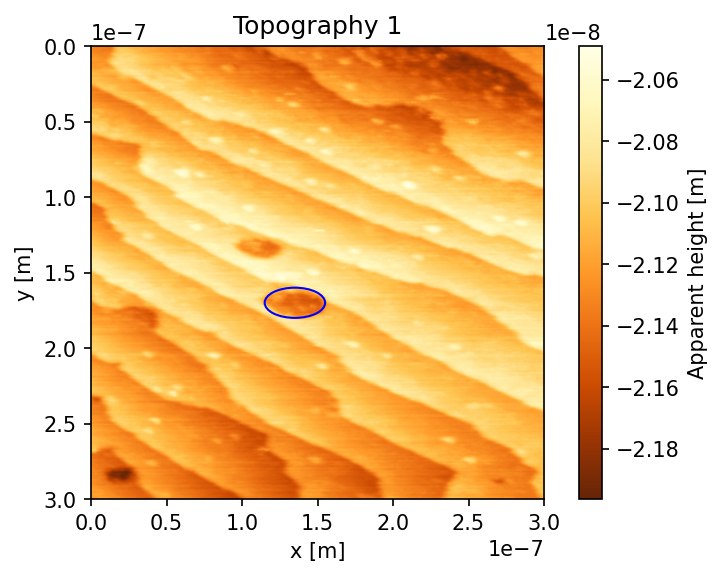

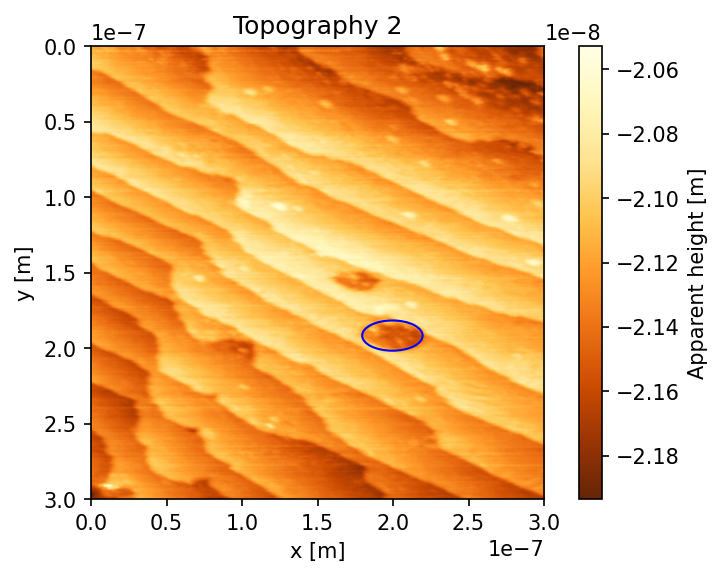

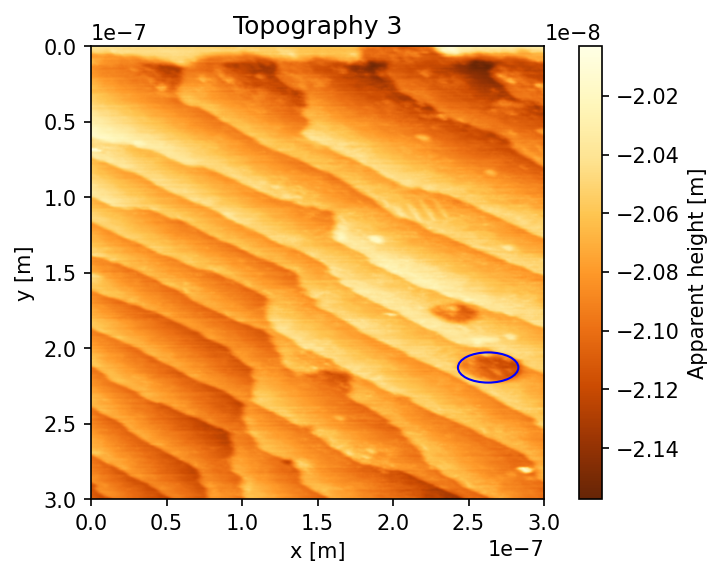

In [15]:
# The following part of the code illustrates the tracking of the drift of the training series.

one = topo_info('testing_2022_02_11_05_48_46_290.txt', 512, 512, -1.8e-6, 1.8e-6, 300e-9, 300e-9)
two = topo_info('testing_2022_02_11_06_23_46_730.txt', 512, 512, -1.8e-6, 1.8e-6, 300e-9, 300e-9)
three = topo_info('testing_2022_02_11_06_58_47_170.txt', 512, 512, -1.8e-6, 1.8e-6, 300e-9, 300e-9)

img_one = one
img_two = two

cx = 1.35e-7
cy = 1.7e-7
w = 0.4e-7
h = 0.2e-7

plt.figure(dpi=150)
p = plt.imshow(one[0], cmap='YlOrBr_r', extent =[one[1].min(), one[1].max(), one[2].max(), one[2].min()])
cbar = plt.colorbar(p) 
cbar.set_label('Apparent height [m]')   
outline = Ellipse((cx, cy), w, h, color='b', fill=False)
fig = plt.gcf()
ax = fig.gca()
ax.add_patch(outline)
plt.title('Topography 1')                                                              
plt.ylabel('y [m]')
plt.xlabel('x [m]')
plt.show()

drift = drift_calc(img_one, img_two, cx, cy, w, h)

cx = cx+drift[0]
cy = cy+drift[1]

plt.figure(dpi=150)
p = plt.imshow(two[0], cmap='YlOrBr_r', extent =[two[1].min(), two[1].max(), two[2].max(), two[2].min()])
cbar = plt.colorbar(p) 
cbar.set_label('Apparent height [m]')    
outline = Ellipse((cx, cy), w, h, color='b', fill=False)
fig = plt.gcf()
ax = fig.gca()
ax.add_patch(outline)
plt.title('Topography 2')                                                              
plt.ylabel('y [m]')
plt.xlabel('x [m]')
plt.show()

img_one = two
img_two = three

drift = drift_calc(img_one, img_two, cx, cy, w, h)

cx = cx+drift[0]
cy = cy+drift[1]

plt.figure(dpi=150)
p = plt.imshow(three[0], cmap='YlOrBr_r', extent =[three[1].min(), three[1].max(), three[2].max(), three[2].min()])
cbar = plt.colorbar(p) 
cbar.set_label('Apparent height [m]')   
outline = Ellipse((cx, cy), w, h, color='b', fill=False)
fig = plt.gcf()
ax = fig.gca()
ax.add_patch(outline)
plt.title('Topography 3')                                                              
plt.ylabel('y [m]')
plt.xlabel('x [m]')
plt.show()

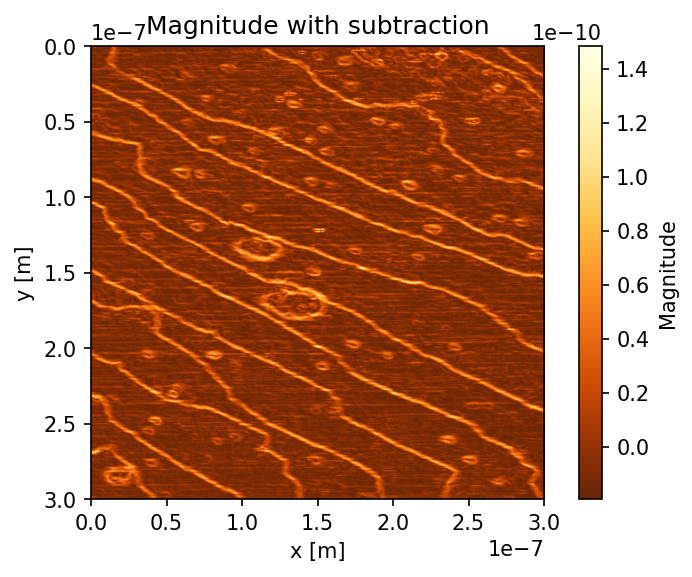

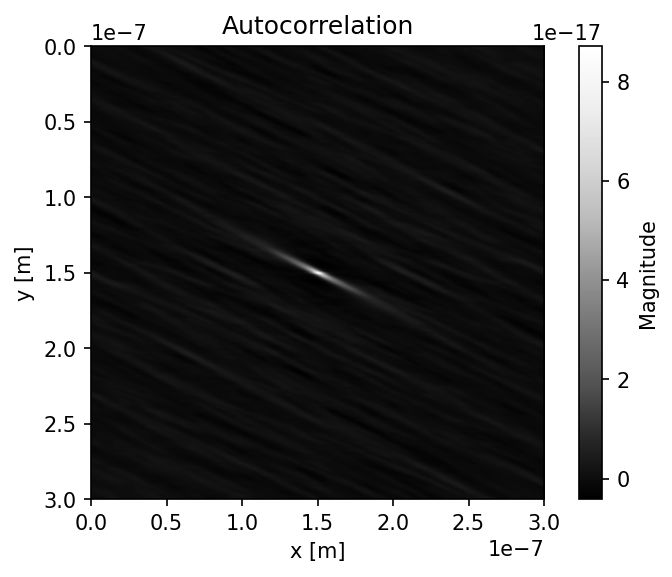

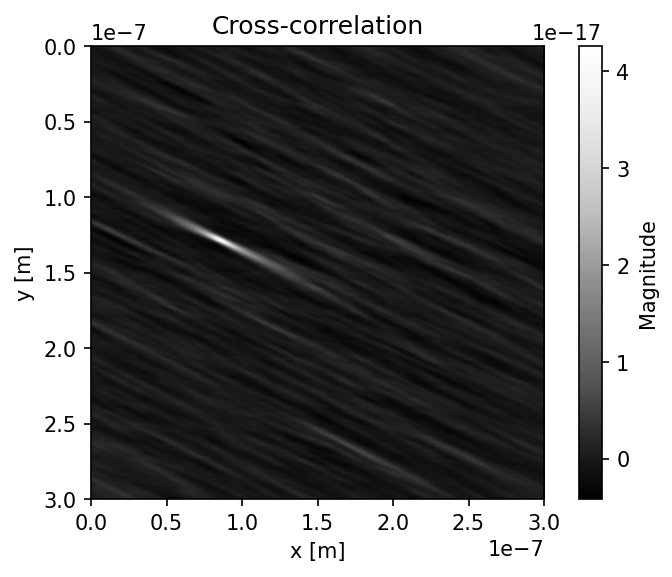

Drift = ( 6.457925636007827e-08 , 2.172211350293542e-08 ) m
Circle centre = ( 1.9957925636007828e-07 , 1.917221135029354e-07 ) m
Apparent height of mol_one via the crude method = 1.0629702000000014e-09 +/- 7.346998731974708e-11 m
Apparent height of mol_two via the crude method = 9.748935000000046e-10 +/- 7.346998731974708e-11 m
Apparent height of mol_three via the crude method = 1.1207915000000119e-09 +/- 7.346998731974708e-11 m
Mean apparent height via the crude method = 1.0528850666666727e-09 +/- 4.2417916956414374e-11 m


In [18]:
# The following part of the code is for the illustration of the correlation steps.

img_one = one
img_two = two

grad1 = np.gradient(img_one[0])
grad2 = np.gradient(img_two[0])
mag1 = np.sqrt(grad1[0]**2 + grad1[1]**2)
mag2 = np.sqrt(grad2[0]**2 + grad2[1]**2)

mag1 -= np.mean(mag1)
mag2 -= np.mean(mag2)

#mag1 = img_one[0]/np.mean(img_one[0]) # This is for the method that uses the normalized topographies.
#mag2 = img_two[0]/np.mean(img_two[0])

plt.figure(dpi=150) # A plot to illustrate what the operations on the topography look like.
p = plt.imshow(mag1, cmap='YlOrBr_r', extent =[img_one[1].min(), img_one[1].max(), img_one[2].max(), img_one[2].min()])
cbar = plt.colorbar(p) 
cbar.set_label('Magnitude')
plt.title('Magnitude with subtraction')                                                              
plt.ylabel('y [m]')
plt.xlabel('x [m]')
plt.show()

corr_sameimg = cross_image(mag1,mag1)
corr_img = cross_image(mag1,mag2)

plt.figure(dpi=150) # A plot to illustrate autocorrelation.
p = plt.imshow(corr_sameimg, cmap='Greys_r', extent =[img_one[1].min(), img_one[1].max(), img_one[2].max(), img_one[2].min()])
cbar = plt.colorbar(p)
cbar.set_label('Magnitude')
plt.title('Autocorrelation')                                                              
plt.ylabel('y [m]')
plt.xlabel('x [m]')
plt.show()

plt.figure(dpi=150) # A plot to illustrate cross-correlation.
p = plt.imshow(corr_img, cmap='Greys_r', extent =[img_one[1].min(), img_one[1].max(), img_one[2].max(), img_one[2].min()])
cbar = plt.colorbar(p)
cbar.set_label('Magnitude')
plt.title('Cross-correlation')                                                              
plt.ylabel('y [m]')
plt.xlabel('x [m]')
plt.show()

cx = 1.35e-7
cy = 1.7e-7
w = 0.4e-7
h = 0.2e-7

drift = drift_calc(img_one, img_two, cx, cy, w, h)

print('Drift = (',drift[0],',',drift[1],')','m')
print('Circle centre = (',cx+drift[0],',',cy+drift[1],')','m')

# These are the apparent heights as calculated by the crude method.

ah1 = crude_ah(mol_one, 4.8e-9, 4.5e-9, 2*2e-9, 2*2e-9) # The coordinates of the circles returned by the drift are inputs
ah2 = crude_ah(mol_two, 4.327304347826087e-09, 3.7113207547169807e-09, 2*2e-9, 2*2e-9)
ah3 = crude_ah(mol_three, 6.1540760013693945e-09, 3.3333679988114687e-09, 2*2e-9, 2*2e-9)
       
meanah = (ah1+ah2+ah3)/3
       
unbiased_error = np.sqrt(np.sum(([ah1,ah2,ah3]-meanah)**2)/(3-1))
standard_error = unbiased_error/np.sqrt(3)

print('Apparent height of mol_one via the crude method =', ah1, '+/-', unbiased_error,'m')
print('Apparent height of mol_two via the crude method =', ah2, '+/-', unbiased_error,'m')
print('Apparent height of mol_three via the crude method =', ah3, '+/-', unbiased_error,'m')
       
print('Mean apparent height via the crude method =', meanah, '+/-', standard_error,'m')

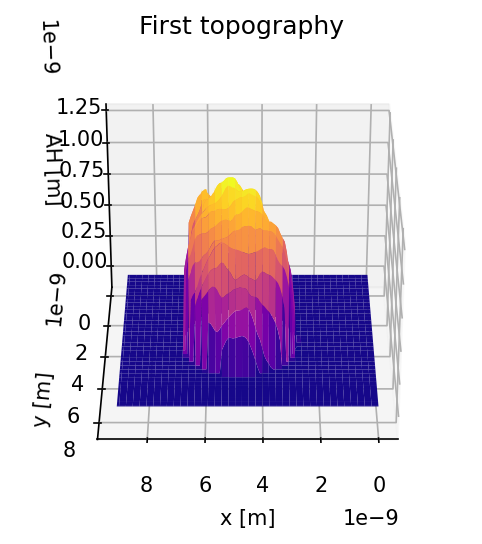

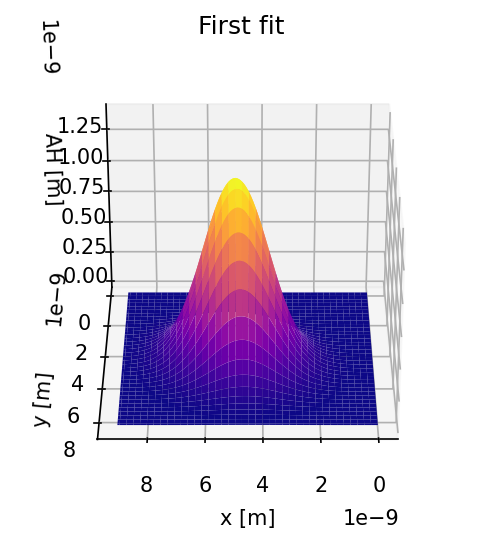

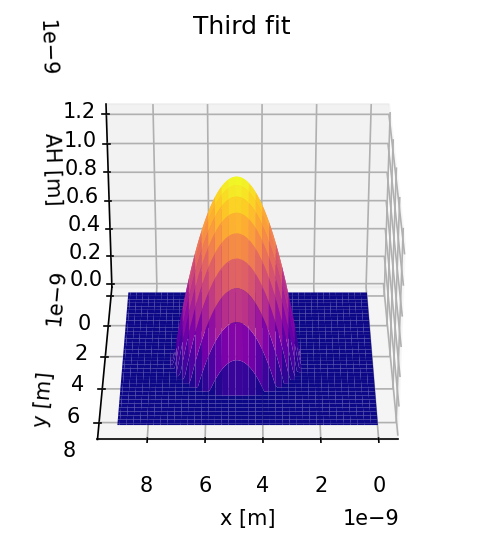

Apparent height of mol_one via the gaussian fit = 1.4195067983843248e-09 +/- 1.9776740391269614e-09 m
Apparent height of mol_two via the gaussian fit = 1.3097068076781953e-09 +/- 1.9776740391269614e-09 m
Apparent height of mol_three via the gaussian fit = 1.466066566067271e-09 +/- 1.9776740391269614e-09 m
Mean of the apparent height via the gaussian fit = 1.3984267240432636e-09 +/- 1.1418106388592856e-09 m
Apparent height of mol_one via the paraboloid fit = 1.2439746423142849e-09 +/- 1.7363021010152812e-09 m
Apparent height of mol_two via the paraboloid fit = 1.1415802174051473e-09 +/- 1.7363021010152812e-09 m
Apparent height of mol_three via the paraboloid fit = 1.2976981097296336e-09 +/- 1.7363021010152812e-09 m
Mean of the apparent height via the paraboloid fit = 1.227750989816355e-09 +/- 1.0024544854156854e-09 m
Apparent height of mol_one via the gaussian fit = 1.4195067983843248e-09 +/- 5.390003325172614e-12 m
Apparent height of mol_two via the gaussian fit = 1.3097068076781953e-0

In [17]:
# The following part of the code is for the 3D plotting of the suspected single-molecule and the calculation of its apparent
# height via 2D fitting.

cx = 4.8e-9 # Coordinates for the first topography of the suspected single-molecule.
cy = 4.5e-9
w = 2*2e-9
h = 2*2e-9

drift = drift_calc(mol_one, mol_two, cx, cy, w, h)

cx2 = cx+drift[0] # Coordinates for the second topography of the suspected single-molecule.
cy2 = cy+drift[1]

drift = drift_calc(mol_two, mol_three, cx2, cy2, w, h)

cx3 = cx2+drift[0] # Coordinates for the third topography of the suspected single-molecule.
cy3 = cy2+drift[1]

fitting_one = TwoDfits(mol_one, cx, cy, w, h)
fitting_two = TwoDfits(mol_two, cx2, cy2, w, h)
fitting_three = TwoDfits(mol_three, cx3, cy3, w, h)

fitting = fitting_one # Choose which topography to plot the topographies and fits of in the following plots.

fig = plt.figure(dpi=150) # The plotting of the topography of the suspected single-molecule.
ax = plt.axes(projection='3d')
ax.plot_surface(fitting[1], fitting[2], fitting[0], cmap='plasma')
ax.view_init(30, 90) # Determines the perspective from which the plot is viewed.
ax.set(xlabel='x [m]', ylabel='y [m]', zlabel='AH [m]')
plt.title('First topography')
plt.show()

fig = plt.figure(dpi=150) # The plotting of the 2D gaussian fit of the topography of the suspected single-molecule.
ax = plt.axes(projection='3d')
ax.plot_surface(fitting[1], fitting[2], fitting[3], cmap='plasma')
ax.view_init(30, 90)
ax.set(xlabel='x [m]', ylabel='y [m]', zlabel='AH [m]')
plt.title('First fit')
plt.show()

fig = plt.figure(dpi=150) # The plotting of the paraboloid fit of the topography of the suspected single-molecule.
ax = plt.axes(projection='3d')
ax.plot_surface(fitting[1], fitting[2], fitting[4], cmap='plasma')
ax.view_init(30, 90)
ax.set(xlabel='x [m]', ylabel='y [m]', zlabel='AH [m]')
plt.title('Third fit')
plt.show()


# The error calculation via unbiased estimator, mean, and standard error.
meanah = (np.max(fitting_one[3])+np.max(fitting_two[3])+np.max(fitting_three[3]))/3
unbiased_error = np.sqrt(np.sum(([np.max(fitting_one[3])+np.max(fitting_two[3])+np.max(fitting_three[3])]-meanah)**2)/(3-1))
standard_error = unbiased_error/np.sqrt(3)

print('Apparent height of mol_one via the gaussian fit =', np.max(fitting_one[3]), '+/-', unbiased_error,'m')
print('Apparent height of mol_two via the gaussian fit =', np.max(fitting_two[3]), '+/-', unbiased_error,'m')
print('Apparent height of mol_three via the gaussian fit =', np.max(fitting_three[3]), '+/-', unbiased_error,'m')
print('Mean of the apparent height via the gaussian fit =', meanah, '+/-', standard_error,'m')

meanah = (np.max(fitting_one[4])+np.max(fitting_two[4])+np.max(fitting_three[4]))/3
unbiased_error = np.sqrt(np.sum(([np.max(fitting_one[4])+np.max(fitting_two[4])+np.max(fitting_three[4])]-meanah)**2)/(3-1))
standard_error = unbiased_error/np.sqrt(3)

print('Apparent height of mol_one via the paraboloid fit =', np.max(fitting_one[4]), '+/-', unbiased_error,'m')
print('Apparent height of mol_two via the paraboloid fit =', np.max(fitting_two[4]), '+/-', unbiased_error,'m')
print('Apparent height of mol_three via the paraboloid fit =', np.max(fitting_three[4]), '+/-', unbiased_error,'m')
print('Mean of the apparent height via the paraboloid fit =', meanah, '+/-', standard_error,'m')

# The error calculation via the fitting function and weighted average.
print('Apparent height of mol_one via the gaussian fit =', np.max(fitting_one[3]), '+/-',
      np.sqrt(np.diag(fitting_one[6])[1]),'m')
print('Apparent height of mol_two via the gaussian fit =', np.max(fitting_two[3]), '+/-',
      np.sqrt(np.diag(fitting_two[6])[1]),'m')
print('Apparent height of mol_three via the gaussian fit =', np.max(fitting_three[3]), '+/-',
      np.sqrt(np.diag(fitting_three[6])[1]),'m')

weights = 1/np.array([np.diag(fitting_one[6])[1],np.diag(fitting_two[6])[1],np.diag(fitting_three[6])[1]])
weighted_av = np.sum(weights*[np.max(fitting_one[3]),np.max(fitting_two[3]),np.max(fitting_three[3])])/np.sum(weights)
weighted_av_er = np.sqrt(1/np.sum(weights))

print('Weighted average of the apparent height via the gaussian fit =', weighted_av, '+/-', weighted_av_er,'m')

print('Apparent height of mol_one via the paraboloid fit =', np.max(fitting_one[4]), '+/-',
      np.sqrt(np.abs(np.diag(fitting_one[8])[1])),'m')
print('Apparent height of mol_two via the paraboloid fit =', np.max(fitting_two[4]), '+/-',
      np.sqrt(np.abs(np.diag(fitting_two[8])[1])),'m')
print('Apparent height of mol_three via the paraboloid fit =', np.max(fitting_three[4]), '+/-',
      np.sqrt(np.abs(np.diag(fitting_three[8])[1])),'m')

weights = 1/np.array(np.abs([np.diag(fitting_one[8])[1],np.diag(fitting_two[8])[1],np.diag(fitting_three[8])[1]]))
weighted_av = np.sum(weights*[np.max(fitting_one[4]),np.max(fitting_two[4]),np.max(fitting_three[4])])/np.sum(weights)
weighted_av_er = np.sqrt(1/np.sum(weights))

print('Weighted average of the apparent height via the paraboloid fit =', weighted_av, '+/-', weighted_av_er,'m')